In [1]:
# imports
import os
import torch 
import torchvision
import numpy as np
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision.utils import save_image
from google.colab import drive # Модуль для работы с Google Disk
from PIL import Image

In [2]:
NUM_EPOCHS = 5
LEARNING_RATE = 0.001
BATCH_SIZE = 16
NOISE_FACTOR = 0.5

In [12]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:

samples_mean, samples_std = [0.4579, 0.3860, 0.3744], [0.2649, 0.2518, 0.2480]
 
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(samples_mean, samples_std)
])
 
trainset = datasets.STL10(
    root='./data',
    split='unlabeled',
    download=True,
    transform=transform
)
testset = datasets.STL10(
    root='./data',
    split='test',
    download=True,
    transform=transform
)
trainloader = DataLoader(
    trainset, 
    batch_size=BATCH_SIZE,
    shuffle=True
)
testloader = DataLoader(
    testset, 
    batch_size=BATCH_SIZE, 
    shuffle=True
)

Files already downloaded and verified
Files already downloaded and verified


In [14]:
def get_device():
    if torch.cuda.is_available():
        device = 'cuda:0'
    else:
        device = 'cpu'
    return device
def make_dir():
    image_dir = 'Saved_Images'
    if not os.path.exists(image_dir):
        os.makedirs(image_dir)
def save_decoded_image(img, name):
    img = img.view(img.size(0), 3, 96, 96)
    save_image(img, name)

In [73]:
# the autoencoder network
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # encoder layers
        self.enc1 = nn.Sequential(nn.Conv2d(3, 128, kernel_size=3, padding=0),nn.ReLU(),nn.MaxPool2d(2, 2))
        self.enc2 = nn.Sequential(nn.Conv2d(128, 64, kernel_size=3, padding=1),nn.ReLU(),nn.MaxPool2d(2, 2))
        self.enc3 = nn.Sequential(nn.Conv2d(64, 32, kernel_size=3, padding=1),nn.ReLU(),nn.MaxPool2d(2, 2))
        self.enc4 = nn.Sequential(nn.Conv2d(32, 16, kernel_size=3, padding=1),nn.ReLU(),nn.MaxPool2d(2, 2))
        
        # decoder layers
        self.dec1 = nn.ConvTranspose2d(16, 16, kernel_size=3, stride=2) 
        self.dec2 = nn.ConvTranspose2d(16, 32, kernel_size=3, stride=2)
        self.dec3 = nn.ConvTranspose2d(32, 64, kernel_size=3, stride=2)
        self.dec4 = nn.ConvTranspose2d(64, 128, kernel_size=4, stride=2)
        self.out = nn.Conv2d(128, 3, kernel_size=3, padding=1)
    def forward(self, x):
        # encode
        x = self.enc1(x)
        x = self.enc2(x)
        x = self.enc3(x)
        x = self.enc4(x)
        
        # decode
        x = F.relu(self.dec1(x))
        x = F.relu(self.dec2(x))
        x = F.relu(self.dec3(x))
        x = F.relu(self.dec4(x))
        x = torch.sigmoid(self.out(x))
        return x
net = Autoencoder()
print(net)

Autoencoder(
  (enc1): Sequential(
    (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (enc2): Sequential(
    (0): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (enc3): Sequential(
    (0): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (enc4): Sequential(
    (0): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (dec1): ConvTranspose2d(16, 16, kernel_size=(3, 3), stride=(2, 2))
  (dec2): ConvTranspose2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
  (dec3): ConvTranspose2d(32, 64, kernel_size=(3, 3), stride

In [16]:
# the loss function
criterion = nn.MSELoss()
# the optimizer
optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE)

In [25]:
def train(net, trainloader, NUM_EPOCHS):
    train_loss = []
    for epoch in range(NUM_EPOCHS):
        running_loss = 0.0
        for data in trainloader:
            img, _ = data # we do not need the image labels
            # add noise to the image data
            img_noisy = img + NOISE_FACTOR * torch.randn(img.shape)
            # clip to make the values fall between 0 and 1
            img_noisy = np.clip(img_noisy, 0., 1.)
            img = np.clip(img, 0., 1.)
            x = np.random.randint(66)
            y = np.random.randint(66)
            img_noisy[:,:,x:x+30,y:y+30] = 0
            img_noisy = img_noisy.to(device)
            img = img.to(device)

            optimizer.zero_grad()
            outputs = net(img_noisy)
            loss = criterion(outputs, img)
            # backpropagation
            loss.backward()
            # update the parameters
            optimizer.step()
            running_loss += loss.item()
        
        loss = running_loss / len(trainloader)
        train_loss.append(loss)
        print('Epoch {} of {}, Train Loss: {:.3f}'.format(
            epoch+1, NUM_EPOCHS, loss))
        save_decoded_image(img_noisy.cpu().data, name='./Saved_Images/noisy{}.png'.format(epoch))
        save_decoded_image(outputs.cpu().data, name='./Saved_Images/denoised{}.png'.format(epoch))
    return train_loss

cuda:0
Epoch 1 of 5, Train Loss: 0.048
Epoch 2 of 5, Train Loss: 0.047
Epoch 3 of 5, Train Loss: 0.046
Epoch 4 of 5, Train Loss: 0.046
Epoch 5 of 5, Train Loss: 0.045


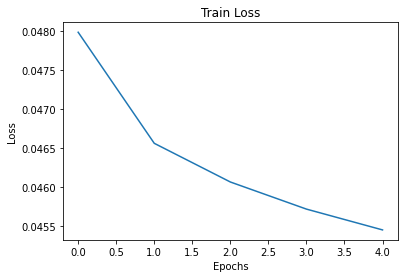

In [26]:
device = get_device()
print(device)
net.to(device)
make_dir()
train_loss = train(net, trainloader, NUM_EPOCHS)
plt.figure()
plt.plot(train_loss)
plt.title('Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.savefig('./Saved_Images/conv_ae_stl10_loss.png')

In [27]:
torch.save(net.state_dict(),'/content/drive/My Drive/Colab Notebooks/Models/AutoEncoderSTL10.pth')

In [57]:
def test_image_reconstruction(net, testset):
    img = torch.zeros([10,3,96,96],dtype=torch.float64)
    class_nums = [i for i in range(0,10)]
    for sample in testset:
        if sample[1] in class_nums:
            img[sample[1]] = torch.Tensor(sample[0])
            class_nums.remove(sample[1])
    img_noisy = img + NOISE_FACTOR * torch.randn(img.shape)
    img_noisy = np.clip(img_noisy, 0., 1.)
    img = np.clip(img, 0., 1.)
    for i in range(10):
        x = np.random.randint(66)
        y = np.random.randint(66)
        img_noisy[i,:,x:x+30,y:y+30] = 0

    img_noisy = img_noisy.cuda().float()

    outputs = net(img_noisy)
   
    outputs = outputs.view(outputs.size(0), 3, 96, 96).cpu().data
    save_image(img_noisy, 'noisy_test_input_STL10.png',nrow=5)
    save_image(outputs, 'denoised_test_reconstruction_STL10.png',nrow=5)
    save_image(img, 'orig_STL10.png',nrow=5)

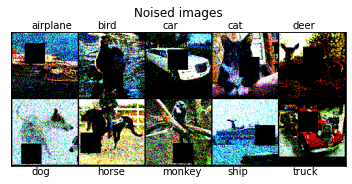

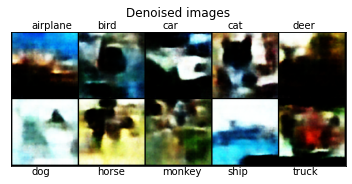

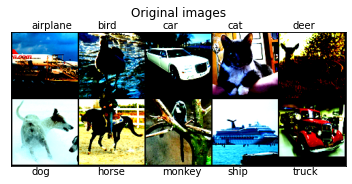

In [66]:
def text(class_list):
    for i in range(2):
        for j in range(5):
            plt.text(j*96+30,i*215-5,class_list[i][j])

def show_img(img):
    fig = plt.imshow(img)
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
    text(class_list)
    plt.show()


netSTL10 = Autoencoder().cuda()
STL10 = torch.load('/content/drive/My Drive/Colab Notebooks/Models/AutoEncoderSTL10.pth')
netSTL10.load_state_dict(STL10)

class_list = ['airplane bird car cat deer'.split(' '), 'dog horse monkey ship truck'.split(' ')]

test_image_reconstruction(netSTL10, testset)
img_noisy=plt.imread('noisy_test_input_STL10.png')
img_output = plt.imread('denoised_test_reconstruction_STL10.png')
img_orig = plt.imread('orig_STL10.png')

plt.title('Noised images',pad=15)
show_img(img_noisy)
plt.title('Denoised images',pad=15)
show_img(img_output)
plt.title('Original images',pad=15)
show_img(img_orig)

In [ ]:
|